# Introduction to the advanced functionality of the CalAdapt Python Toolbox and the CalAdapt Library (helper module) for custom analyses
### This cookbook demonstrated using the CalAdapt Python Toolbox in a Jupyter Notebook to perform an advanced analyses of the downloaded NetCDF data from the Cal Adapt FTP Servers.
#### To complete this notebook you will need to add a package to your ArcGIS Python environment.
To add a package to your ArcGIS Python environment you need to have a cloned environment in ArcGIS.  ArcGIS Pro's default python environment is locked and does not allow new packages to the environment.  To clone an environment follow the instructions found here: https://pro.arcgis.com/en/pro-app/latest/arcpy/get-started/work-with-python-environments.htm.
![](cloneWindow.png)
After you clone and activate your environment in ArcGIS Pro you need to install the Dask package that is needed for working with the NetCDF data.  This package is needed by the XARRAY package to work with large netcdf files.  To install packages follow the instructions here https://pro.arcgis.com/en/pro-app/latest/arcpy/get-started/work-with-python-packages.htm and seach and install DASK.
#### To use the CalAdapt Python Toolbox and the CalAdapt Library (helper module) please do the following
Download the zip file from github and uncompress the zip file  into your project folder. For ArcGIS, load the python toolbox into your ArcGIS Project and use the tools in the toolbox. For Python, import the libarary and use the different modules as needed.

## In this Notebook we will demonstrate how to download and analyze the netcdf data available on the CalAdapt FTP server.
In this analysis we will download and analyze 5 years worth of climate data to look at how the cumulative number of growing degrees days (defined below) change over time.  You will download the netcdf data and use a user defined growing degree days (GDD) module to analyze the climate data.  To learn more about the GDDs module visit the Load Non-Standard Python Libraries section below.

### Definition of Growing Degree Days and different methods for calculating.

https://en.wikipedia.org/wiki/Growing_degree-day

GDD are calculated by taking the integral of warmth above a base temperature,[1] Tbase (usually 10 °C):

GDDs are typically measured from the winter low. Any temperature below Tbase is set to Tbase before calculating the average. Likewise, the maximum temperature is usually capped at 30 °C because most plants and insects do not grow any faster above that temperature. However, some warm temperate and tropical plants do have significant requirements for days above 30 °C to mature fruit or seeds.

Example of GDD calculation
For example, a day with a high of 23 °C and a low of 12 °C (and a base of 10 °C) would contribute 7.5 GDDs.

((23+12)/2)-10=7.5

As a second example, a day with a high of 13 °C and a low of 5 °C (and a base of 10 °C) would contribute:

version A: 0 GDD, as:  max((13+5)/2-10,0)=0

version B: 1.5 GDDs, as: (13+10)/2-10=11.5-10=1.5

### Load Standard Python Libraries

Below we are loading the standard python libraries needed for this cookbook.

In [1]:
%matplotlib inline

import arcpy
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib.util

### Load Non-Standard Python Libraries

Below we are loading the non-standard python libraries needed for this cookbook.  These include CalAdaptpy tookbox (https://ucanr-igis.github.io/caladapt-py/) and the HeatUnits.py file that includes the functions for calculating different methods of Growing Degree Days as described in Zalom, F.G., P.B. Goodell, L.T. Wilson, W.W. Barnett, and W.J. Bentley.  1983.  Degree-days: The calculation and use of heat units in pest management.  UC DANR Leaflet 21373.
https://www.researchgate.net/publication/262337197_Degree-Days_the_Calculation_and_Use_of_Heat_Units_in_Pest_Management_University_of_California_Division_of_Agriculture_and_Natural_Resources_Leaflet_21373

The HeatUnits.py module can be downloaded from https://ucanr-igis.github.io/caladapt-py/notebooks/HeatUnits.py.

*!!!Change the 'spec' and 'arcpy.ImportToolbox' varibles to match the locations on your computer*

In [2]:
#  Change the path to reflect the path to the HeatUnits.py file
spec = importlib.util.spec_from_file_location("HeatUnits", r"D:\Data\ArcGIS\Projects\CalAdapt_Cookbook\HeatUnits.py")
hu = importlib.util.module_from_spec(spec)
spec.loader.exec_module(hu)

#  Change the path to reflect the path to the CalAdapt.pyt file
arcpy.ImportToolbox(r'D:\Data\ArcGIS\Projects\CalAdapt_Cookbook\CalAdaptLib\CalAdapt.pyt','')


<module ''>

### Function used to determine if year is in the historic (1950-2005) or future (2006-2100) datasets and assign appropriate scenario

In [3]:
def chooseScenario(year, fScenario):
    # logic to determine if Time is historic (1950-2005) or future data (2006-2100) and assign appropriate scenario
    if year <= 2005:
        scenario = "historical"
    else:
        #options for future scenarios are rcp85 (The high-emissions ‘RCP8.5’ global warming scenario ['Business as usual'] and rcp45 (an intermediate scenario.[10] Emissions in RCP 4.5 peak around 2040, then decline).
        scenario = fScenario
    return scenario

###  Function that will calculate the cumulative daily Growing Degree Days (GDD) for a given year
In the function we are calculating the growing days for the California water.  The water year starts on October 1st and ends on September 31st.  Therefore we use two years of temperature data in this calculation

In [4]:
def applyGDDFunction(Time, gcm, scenario):
    # Load the previous years temperature data
    TimePast = Time - 1
    fileNames = "%s/*_day_%s_%s_*_%s0101-%s1231.LOCA_2016-04-02.16th.CA_NV.nc" % (netcdf_loc, gcm, chooseScenario(TimePast,scenario), TimePast, TimePast)
    ds0 = xr.open_mfdataset(fileNames)#,chunks={'lat': 50, 'lon': 50, 'time': -1})
    
    # Load the years temperature data
    fileNames = "%s/*_day_%s_%s_*_%s0101-%s1231.LOCA_2016-04-02.16th.CA_NV.nc" % (netcdf_loc, gcm, chooseScenario(Time,scenario), Time, Time)
    ds1 = xr.open_mfdataset(fileNames)#,chunks={'lat': 50, 'lon': 50, 'time': -1})
   
    # Merge both time periods into one dataset
    ds = ds0.merge(ds1)
    
    # set variables that represent the start and end date of the water year
    t1 = "%s-10-1" % (TimePast)
    t2 = "%s-9-30" % (Time)
    
    # Select only the days between and including the start and end dates of the water year
    ds = ds.sel(time=slice(t1,t2))
    
    # Convert temperatures from Kelvin (K) to Farhenheit (F)
    ds['tasmin'] = ((ds.tasmin - 273.15) * (9 / 5)) + 32
    ds['tasmax'] = ((ds.tasmax - 273.15) * (9 / 5)) + 32
    
    # convert the xarray data array to a pandas dataframe. This is needed because the heatunit.py functions are built to work with pandas dataframe structures and not xarray's 
    ds3 = ds.to_dataframe()
    
    # Compute the GDD using the Single Sine method with a 50F minimum and 90F maximum thresholds, with no cutoff applied [90F upper threshold ignored])
    ds3['HeatU'] = ds3.apply(lambda x: hu.HeatU(50, 90, 1, 0, 1, x['tasmin'], x['tasmax']), axis=1)
    
    # convert the pandas dataframe back to a xarray data array for further processing
    ds1 = ds3.to_xarray()

    time_array = ds1['time']

    Time_Periods = xr.DataArray([t.year if ((t.month < 9) or ((t.month==9) and (t.day <= 30))) else (t.year + 1) for t in time_array.indexes['time']],
                           dims='time', name='Time_Periods', coords={'time': time_array})

    # use that array of years (integers) to do the groupby
    dst = ds1.groupby(Time_Periods).apply(lambda x: x.cumsum(dim='time', skipna=True))
    dst = dst.rename_vars({'HeatU':'cumhu'})
    ds1 = ds1.drop_vars('tasmax')
    ds1 = ds1.drop_vars('tasmin')

    ds2 = xr.merge([ds1, dst], compat="no_conflicts")
    ds2 = ds2.drop_vars('tasmax')
    ds2 = ds2.drop_vars('tasmin')
    ds2 = ds2.drop_vars('HeatU')

    OutfileName = "%s/GDD_%s_%s_%s1001-%s0930.nc" % (gdd_loc,gcm,chooseScenario(Time,scenario),TimePast, Time)
    ds2.to_netcdf(OutfileName, format='NETCDF3_CLASSIC')
    
    return 

### Create and set variables needed for this cookbook

These variables set the paths for saving outputs data functions and the set the parametrs needed to download the climate models (https://berkeley-gif.github.io/caladapt-docs/data-catalog.html#global-climate-models-gcm) from the CalAdapt Data Server and set the time periods of interest.

*!!!Change the 'netcdf_loc' and 'gdd_loc' varibles to match the locations on your computer*

*!!!In this example we are calculating Growing Degree Day for the Water Year (October 1 - September 30th), due to this we need to include at least 2 years.  Therefore if you were going to calculate growing degree days for one full year your years variable would in the form of:  years = [1950, 1952] where 1952 is the year 1951 + 1 (since python ranges iterate as long as the value is less than the second value specified).*

In [5]:
# Climate variables of interest, both minimum and maximun air temperature
variables = ('tasmin','Tasmax')

# Path to the location to save the netcdf data from the CalAdapt Dataserver
netcdf_loc = r"D:\Data\ArcGIS\Projects\CalAdapt_Cookbook\netcdf"

# Path to the location to save the GDD netcdf data created by running the GDD Script
gdd_loc = r"D:\Data\ArcGIS\Projects\CalAdapt_Cookbook\GDD_netcdf"

# Global Climate model of interest
gcm = "GFDL-CM3"
fScenario = "rcp85"

# Year of interest *In python the upper bounds of the range function is not used (since python ranges iterate as long as the value is less than the second value specified)
#years = [1950,2101] * 150 years of daily data will take hours to run
years = [1950,1956]

### Loop through each year in the range defined by the years list and calculated GDD per year

In [7]:
# loop through each year in the range defined by the years list
for year in range(years[0],years[1]):
    # loops through each year in the years list and downloads the minimum and maximum air temperature netcdf data for California
    for variable in variables:
        arcpy.LOCA_Data("met", gcm, chooseScenario(year,fScenario), variable, year, "", netcdf_loc)
        arcpy.LOCA_Data("met", gcm, chooseScenario(year,fScenario), variable, year, "", netcdf_loc)
            
# loops through each year and apply the Growing Degree Days function
for year in range(years[0]+1,years[1]):
    applyGDDFunction(year,gcm,fScenario)
    print(str(year) + " Completed", end='\r')

###  Load all the GDD netcdfs into memory and treat as one dataset

Note: these data are daily estimates of Growing Degree Days GDD covering the time period 1950-2100.  Look at the Dimensions data to see home many time periods are in the dataset.

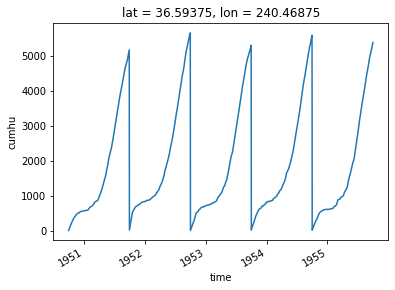

<xarray.Dataset>
Dimensions:  (lat: 195, lon: 179, time: 1826)
Coordinates:
  * time     (time) datetime64[ns] 1950-10-01T12:00:00 ... 1955-09-30T12:00:00
  * lat      (lat) float64 31.59 31.66 31.72 31.78 ... 43.53 43.59 43.66 43.72
  * lon      (lon) float64 235.5 235.5 235.6 235.7 ... 246.4 246.5 246.5 246.6
Data variables:
    cumhu    (lat, lon, time) float64 dask.array<chunksize=(195, 179, 365), meta=np.ndarray>

In [6]:
path1 = "%s\*.nc" % (gdd_loc)
ds = xr.open_mfdataset(path1)#,chunks={'lat': 50, 'lon': 50, 'time': -1})

gddplt = ds.cumhu.isel(lat=80, lon=80)

gddplt.plot()
plt.show()

ds

### Using xarray you can Resample the data to a different time frequency.
In the example below we resample the data from a daily time step to a monthly timestep.  Note we use offset objects as defined here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

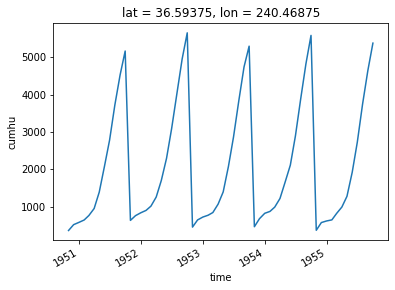

<xarray.Dataset>
Dimensions:  (lat: 195, lon: 179, time: 60)
Coordinates:
  * time     (time) datetime64[ns] 1950-10-31 1950-11-30 ... 1955-09-30
  * lat      (lat) float64 31.59 31.66 31.72 31.78 ... 43.53 43.59 43.66 43.72
  * lon      (lon) float64 235.5 235.5 235.6 235.7 ... 246.4 246.5 246.5 246.6
Data variables:
    cumhu    (time, lat, lon) float64 dask.array<chunksize=(1, 195, 179), meta=np.ndarray>

In [9]:
# resampled the data yearly and return the maximum gdd per cell of the netcdf data, with the year starting October 1 and ending September 31st.
# ds1 = ds.resample(time="A-SEP").max() # if resampling yearly to correspond to the water year (A-Sep = Annually Oct-Sep)
ds1 = ds.resample(time="M").max()

gddplt = ds1.cumhu.isel(lat=80, lon=80)

gddplt.plot()
plt.show()

ds1

### Using xarray we saved the resampled data as a new netcdf data file that can be opened and used in ArcGIS

*!!!Change the 'OutfileName'*

In [10]:
OutfileName = r'D:\Data\ArcGIS\Projects\CalAdapt_Cookbook\GDD_%s_%s_%s1001-%s0930.nc' % (gcm,"M",years[0],years[1])
ds1.to_netcdf(OutfileName, format='NETCDF3_CLASSIC')

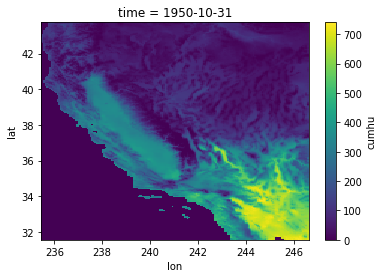

In [11]:
gddplt = ds1.cumhu.isel(time=0)

gddplt.plot()
plt.show()